In [1]:
# Byzantine Generals, N consensus using Qiskit, OOP Approach

# Import statements
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import copy, random, itertools
from scipy.special import comb
from qiskit.visualization import plot_histogram  # Visualizing stuff
from qiskit import QuantumRegister, QuantumCircuit, execute
from qiskit_aer import AerSimulator
import qiskit_aer.noise as ns

#  Aesthetic Preferences

#matplotlib.use( 'tkagg' )
#matplotlib.use('Agg')
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))

from qiskit_ibm_provider import IBMProvider

In [2]:
# Creating General Class for OOP Approach

class General():
    def __init__(self, general_number=1, is_commander=False):
        self.id = general_number
        self.is_commander = is_commander
        self.is_traitor = False
        self.states = None
        self.orders = None
        self.indices = None
        self.action = None
        
    def __repr__(self):
        return f"General Number:{self.id}, Is Commander:{self.is_commander}, Is Traitor:{self.is_traitor}, Has States:{self.states is not None} \n"
    
    def receive_states(self, state_array):
        self.states = state_array[self.id, :]
    
    def receive_orders(self, order, indices):
        self.orders = order
        self.indices = indices
        # Some test of the commanders indices should be inserted here
        if self.is_traitor:
            self.indices = np.where(self.states == self.orders)[0]
            self.orders = not self.orders
            

class Byzantine_Problem():
    
    def __init__(self, N_gen, shots=10000, noise=False, noise_level=0.01):
        self.N_gen = N_gen  # must be >= 2
        self.shots = shots  # max 12615
        self.provider = IBMProvider()

        hub = "qc-spring-23-2"
        group = "group-1"
        project = "rec2p8vsiAmHZqv6X"

        backend_name = "ibm_peekskill"
        self.backend = self.provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")
        
        self.noise = noise
        if noise:
            # Depolarizing quantum errors
            noise_model = ns.NoiseModel()
            noise_model.add_all_qubit_quantum_error(ns.depolarizing_error(noise_level, 1),  ['rz'])  # single qubit z-rotation error
            self.backend = AerSimulator(noise_model=noise_model)
            
        self.circuit = QuantumCircuit(self.N_gen+1)  # arg: number of qubits
        self.generals_list = []
        self.initial_state = None
        self.measurements = np.zeros((self.N_gen, self.shots), dtype=int)  # Initializing array with a row for each general, and space to store the corresponding orders 0/1/2 retreat, attack, neither
        self.populate()
        self.get_initial_state()
    
    
    def __repr__(self):
        return f"BP Object, with {self.N_gen} Generals"

    def populate(self):
        self.generals_list.append(General(0, is_commander=True))
        for i in range(1,self.N_gen):
            self.generals_list.append(General(i, is_commander=False))
    
    def flip_allegiance(self, *general_number):
        for val in general_number:
            self.generals_list[val].is_traitor = not self.generals_list[val].is_traitor
    
    def get_initial_state(self):
            # Preparing the initial state as numpy array, values are amplitudes
        state = np.zeros(2**(self.N_gen+1))
        state[2**(self.N_gen-1)-1] = np.sqrt(1/3)  # Retreat order from commander
        state[2**(self.N_gen) + 2**(self.N_gen-1)] = np.sqrt(1/3)  # Attack order from commander
        for i in range(self.N_gen-1):
            state[2**(self.N_gen-1) + 2**i] = np.sqrt(1/(6*self.N_gen-6))  # commander '01'
            state[2**(self.N_gen) + 2**(self.N_gen-1) - 1 - 2**i] = np.sqrt(1/(6*self.N_gen-6))  # commander '10'
        self.initial_state = state

    def counts_to_memory(self, counts):
        memory = []
        for bitstring, count in counts.items():
            memory.extend([bitstring] * count)
        return memory    
    
    def run_circuit(self, visualize=False, error_mitigation=False):
        self.circuit.initialize(self.initial_state, self.circuit.qubits)   
        self.circuit.measure_active()
        if visualize:
            display(self.circuit.draw(output='mpl'))

        job = execute(self.circuit, backend=self.backend, shots=self.shots)
        results = job.result()
        counts = results.get_counts(self.circuit)
        self.memory = self.counts_to_memory(counts)

        if visualize:
            hist = plot_histogram([counts])
            hist.show()        
        

    def distribute_states(self):
        # Converting into Array of corresponding orders
        v_dic = {'00': 0, '01': 2,  '10': 2,  '11' : 1, '0' :  0, '1' : 1}  # convert bitstrings to n_its and store them
        for i, bitstring in enumerate(self.memory):
            self.measurements[0][i] = v_dic[bitstring[0:2]] # Commander 2 indices
            for j in range(self.N_gen-1):
                self.measurements[j+1][i] = v_dic[bitstring[j+2]]
        for gen in self.generals_list:
            gen.receive_states(self.measurements)
    
    def get_verification_threshold(self, rounds, conf):
        t, sum = 0, 0.0
        while sum < conf:
            sum += comb(rounds, t) * (2/(3*(self.N_gen-1)))**t * (1 - 2/(3*(self.N_gen-1)))**(rounds-t)
            t += 1
        return t

    def verify_entanglement(self, conf=0.995):
        rounds = self.shots//10  # 10% sample for initial verification
        threshold = self.get_verification_threshold(rounds=rounds, conf=conf)
        pairs = list(itertools.combinations(self.generals_list[1:], 2))
        for pair in pairs:
            fails = 0
            for round in range(rounds):
                index = np.random.randint(self.shots)
                fails += int(pair[0].states[index] != pair[1].states[index])
            if fails > threshold:
                # print("State Corrupted.")
                for gen in self.generals_list:
                    gen.action = False

    def send_orders(self):
        """When the commander is loyal, a random order is first selected, corresponding indices are chosen and the lieutentants receive the same items.
        When the commander is a traitor, under rational agent assumptions, to minimize consensus half of the lieutentants receive one order (correct) and half receive the other.
        Along with the corresponding indices. This is acheived by randomly reassigning order."""
        if not self.generals_list[0].is_traitor:  # Loyal General Case
            order = bool(random.getrandbits(1))
            indices = np.where(self.measurements[0] == order)[0]
            for gen in self.generals_list:
                gen.receive_orders(order, indices)
        else:
            for gen in self.generals_list:  # Traitor General Case
                order = bool(random.getrandbits(1))
                indices = np.where(self.measurements[0] == order)[0]
                gen.receive_orders(order, indices)
        self.generals_list[0].action = order

    def get_traitor_detection_threshold(self, rounds, conf):
        t, sum = 0, 0.0
        while sum < 1-conf:
            sum += comb(rounds, t) * (2/(3*(self.N_gen-1)))**t * (1 - 2/(3*(self.N_gen-1)))**(rounds-t)
            t += 1
        t -= 1
        return t

    def realize_agreement(self, conf=0.995, verbose=False):
        pairs = list(itertools.combinations(self.generals_list[1:], 2))
        for pair in pairs:
            self.play(pair, conf, verbose)
        # Locking in actions
        for gen in self.generals_list:
            if gen.action is None:
                gen.action = gen.orders
 
    def play(self, gen_pair, conf, verbose):
        # Check if they agree on the order then initiate game if they do not
        rounds = self.shots//10 # 10% sample for traitor detection
        threshold = self.get_traitor_detection_threshold(rounds, conf)
        if gen_pair[0].orders != gen_pair[1].orders:
            failures = [0, 0]  # number of failures detected by player0 and player1 
            turn = bool(random.getrandbits(1))
            for i in range(rounds):  # Exchanging indices 1 at a time
                if gen_pair[int(turn)].states[gen_pair[int(not turn)].indices[i]] != gen_pair[int(turn)].orders:
                    failures[int(turn)] += 1
                if gen_pair[int(not turn)].states[gen_pair[int(turn)].indices[i]] != gen_pair[int(not turn)].orders:
                    failures[int(not turn)] += 1
                turn = not turn
            if not gen_pair[0].is_traitor:
                if failures[0] > threshold:
                    if verbose:
                        print(f"Lieutenant #{gen_pair[0].id} identifies Lieutenant #{gen_pair[1].id} as a traitor with failure rate {failures[0]/rounds}.")
                else:
                    if verbose:
                        print(f"Lieutenant #{gen_pair[0].id} identifies the Commander as a traitor with failure rate {failures[0]/rounds}.")
                    gen_pair[0].action = False

            if not gen_pair[1].is_traitor:
                if failures[1] > threshold:
                    if verbose:
                        print(f"Lieutenant #{gen_pair[1].id} identifies Lieutenant #{gen_pair[0].id} as a traitor with failure rate {failures[1]/rounds}.")
                else:
                    if verbose:
                        print(f"Lieutenant #{gen_pair[1].id} identifies the Commander as a traitor with failure rate {failures[1]/rounds}.")
                    gen_pair[1].action = False       

    def detectable_broadcast(self):
        loyal_gens = [gen for gen in self.generals_list if not gen.is_traitor]
        # for gen in self.generals_list:
            # print(gen.id, gen.orders, gen.action)
        tally = 0  # need to keep track of agreement
        db_achieved = False  # default false
        if not self.generals_list[0].is_traitor:
            # If commander is loyal, all loyal generals agree on commanders action
            for gen in loyal_gens:
                tally += gen.action == self.generals_list[0].orders
            if tally == len(loyal_gens):
                db_achieved = True
        else:
            # If commander is not loyal, then all loyal generals abort
            for gen in loyal_gens:
                tally += gen.action == 0
            if tally == len(loyal_gens):
                 db_achieved = True
        return db_achieved



In [5]:
test = Byzantine_Problem(5,noise=False)

test.flip_allegiance(0, 1, 2, 3, 4)
test.run_circuit(visualize=True)
test.distribute_states()
test.verify_entanglement()
test.send_orders()
test.realize_agreement()
test.detectable_broadcast()




<Figure size 1213.74x618.722 with 1 Axes>

True

## Test

In [15]:
import time

N = 3  # Run time for N = 25 ~ 
n_traitors = np.arange(0, N, dtype=int)
dba = []
start_time = time.time()  # Start time

for num in n_traitors:
    traitors = np.random.choice(n_traitors, num, replace=False)
    circ = Byzantine_Problem(N, noise=False)
    circ.flip_allegiance(*traitors)
    circ.run_circuit(visualize=False)
    circ.distribute_states()
    circ.verify_entanglement()
    circ.send_orders()
    circ.realize_agreement()
    dba.append((num, circ.detectable_broadcast()))
    #if num % 5 == 0:
        #print(num)

end_time = time.time()  # End time

print(dba)
print("Runtime: ", end_time - start_time, "seconds")

[(0, True), (1, False), (2, True)]
Runtime:  75.03773260116577 seconds


In [16]:
import time

N = 4  # Run time for N = 25 ~ 
n_traitors = np.arange(0, N, dtype=int)
dba = []
start_time = time.time()  # Start time

for num in n_traitors:
    traitors = np.random.choice(n_traitors, num, replace=False)
    circ = Byzantine_Problem(N, noise=False)
    circ.flip_allegiance(*traitors)
    circ.run_circuit(visualize=False)
    circ.distribute_states()
    circ.verify_entanglement()
    circ.send_orders()
    circ.realize_agreement()
    dba.append((num, circ.detectable_broadcast()))
    #if num % 5 == 0:
        #print(num)

end_time = time.time()  # End time

print(dba)
print("Runtime: ", end_time - start_time, "seconds")

[(0, True), (1, False), (2, True), (3, True)]
Runtime:  94.10038328170776 seconds


In [17]:
import time

N = 5  # Run time for N = 25 ~ 
n_traitors = np.arange(0, N, dtype=int)
dba = []
start_time = time.time()  # Start time

for num in n_traitors:
    traitors = np.random.choice(n_traitors, num, replace=False)
    circ = Byzantine_Problem(N, noise=False)
    circ.flip_allegiance(*traitors)
    circ.run_circuit(visualize=False)
    circ.distribute_states()
    circ.verify_entanglement()
    circ.send_orders()
    circ.realize_agreement()
    dba.append((num, circ.detectable_broadcast()))
    #if num % 5 == 0:
        #print(num)

end_time = time.time()  # End time

print(dba)
print("Runtime: ", end_time - start_time, "seconds")

[(0, False), (1, True), (2, False), (3, True), (4, True)]
Runtime:  144.7593114376068 seconds


In [18]:
import time

N = 6  # Run time for N = 25 ~ 
n_traitors = np.arange(0, N, dtype=int)
dba = []
start_time = time.time()  # Start time

for num in n_traitors:
    traitors = np.random.choice(n_traitors, num, replace=False)
    circ = Byzantine_Problem(N, noise=False)
    circ.flip_allegiance(*traitors)
    circ.run_circuit(visualize=False)
    circ.distribute_states()
    circ.verify_entanglement()
    circ.send_orders()
    circ.realize_agreement()
    dba.append((num, circ.detectable_broadcast()))
    #if num % 5 == 0:
        #print(num)

end_time = time.time()  # End time

print(dba)
print("Runtime: ", end_time - start_time, "seconds")

[(0, True), (1, False), (2, True), (3, True), (4, True), (5, True)]
Runtime:  179.03533577919006 seconds


In [14]:
import time

N = 7  # Run time for N = 25 ~ 
n_traitors = np.arange(0, N, dtype=int)
dba = []
start_time = time.time()  # Start time

for num in n_traitors:
    traitors = np.random.choice(n_traitors, num, replace=False)
    circ = Byzantine_Problem(N, noise=False)
    circ.flip_allegiance(*traitors)
    circ.run_circuit(visualize=False)
    circ.distribute_states()
    circ.verify_entanglement()
    circ.send_orders()
    circ.realize_agreement()
    dba.append((num, circ.detectable_broadcast()))
    #if num % 5 == 0:
        #print(num)

end_time = time.time()  # End time

print(dba)
print("Runtime: ", end_time - start_time, "seconds")

[(0, True), (1, True), (2, True), (3, True), (4, True), (5, True), (6, True)]
Runtime:  207.9277572631836 seconds


## For Some Visualizatrions and Analysis

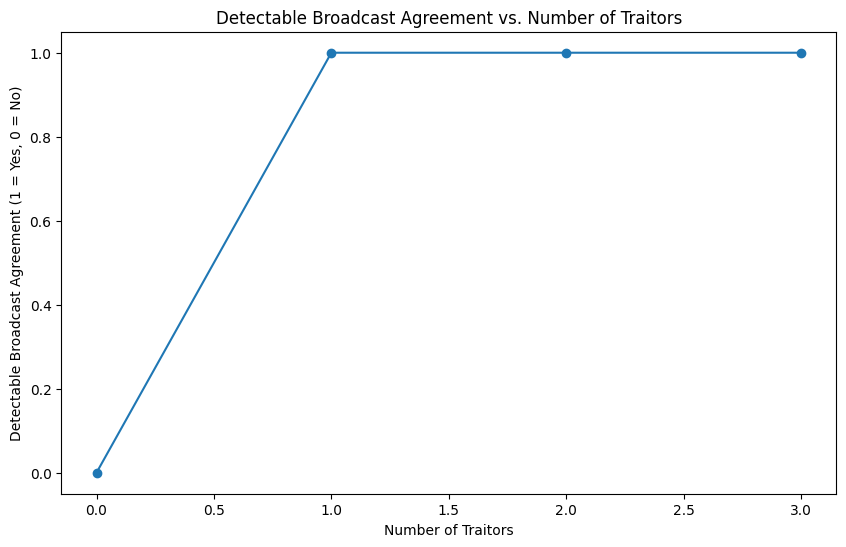

In [8]:
import matplotlib.pyplot as plt

# Unzip the results
traitors, dba_results = zip(*dba)

# Convert boolean results to integer
dba_results = [int(result) for result in dba_results]

plt.figure(figsize=(10, 6))
plt.plot(traitors, dba_results, marker='o')
plt.title("Detectable Broadcast Agreement vs. Number of Traitors")
plt.xlabel("Number of Traitors")
plt.ylabel("Detectable Broadcast Agreement (1 = Yes, 0 = No)")
plt.show()
plt.close()  # close the current figure

In [9]:
# Calculate success rate
success_rate = sum(dba_results) / len(dba_results) * 100
print(f"The success rate of achieving a detectable broadcast agreement was {success_rate}%.")

The success rate of achieving a detectable broadcast agreement was 75.0%.


In [10]:
for num, result in dba:
    print(f"With {num} traitors, detectable broadcast agreement was {'achieved' if result else 'not achieved'}.")

With 0 traitors, detectable broadcast agreement was not achieved.
With 1 traitors, detectable broadcast agreement was achieved.
With 2 traitors, detectable broadcast agreement was achieved.
With 3 traitors, detectable broadcast agreement was achieved.


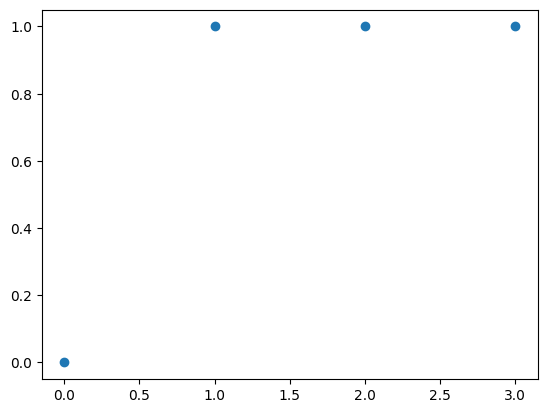

In [11]:
# Plotting
x = [score[0] for score in dba]
y = [score[1] for score in dba]

plt.scatter(x, y)
plt.show()